In [4]:
import tensorflow as tf
import numpy as np
mnist = tf.keras.datasets.mnist

In [32]:
class layer():
    def __init__(self,inputs,units,activation='relu',dropout=False,keep_prob=0.8):
        self.inputs = inputs
        self.units = units
        self.activation = activation
        self.dropout = dropout
        self.keep_prob = keep_prob
        self.b = np.zeros((self.units,1))
        self.input_data = 0
        self.z = 0
        self.a = 0
        self.dw = 0
        self.db = 0
        self.da = 0
        self.vel1 = 0
        self.vel2 = 0
        self.sim1 = 0
        self.sim2 = 0
        self.__initialize_weight()
        
        
    def __sigmoid(self, x):
        
        """
        Computes sigmoid activation.

        Parameters
        ----------
        x : ndarray
            Input vector

        Returns
        -------
        ndarray
            Output vector with applied activation

        """
        return 1 / (1 + np.exp(-x))

    def __initialize_weight(self):
        
        if(self.activation == 'relu'):
            self.w = np.random.rand(self.units,self.inputs) * np.sqrt(2.0/self.inputs)
        elif(self.activation == 'tanh'):
            self.w = np.random.rand(self.units,self.inputs) * np.sqrt(1.0/self.inputs)
        else:
            self.w = np.random.rand(self.units,self.inputs) * np.sqrt(2.0/(self.units+self.inputs))
            
    def __sigmoid_d(self, x):
        
        return x * (1 - x)
    
    def __softmax(self,x):
        """
        Computes softmax activation.
        
        Useful for multi-class classification problems.

        Parameters
        ----------
        x : ndarray
            Input vector

        Returns
        -------
        ndarray
            Output vector with applied activation

        """
        x = x - np.mean(x)
        expx = np.exp(x)
        return expx / expx.sum()
    
    def __tanh(self, x):
        
        """
        Computes tanh activation.

        Parameters
        ----------
        x : ndarray
            Input vector

        Returns
        -------
        ndarray
            Output vector with applied activation

        """
        return 1 / (1 + np.exp(-x))

    def __tanh_d(self, x):
        return (1 + x) * (1 - x)
    
    def __relu(self,x):
        """
        Computes sigmoid activation.

        Parameters
        ----------
        x : ndarray
            Input vector

        Returns
        -------
        ndarray
            Output vector with applied activation

        """
        return np.maximum(0,x) 
    
    def __relu_d(self,x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def update(self,alpha1,alpha2):
        self.w += alpha1
        self.b += alpha2
    
    def forward(self,input_data):
        input_data = input_data.reshape((input_data.shape[0],1))
        self.input_data = input_data
        self.z = np.dot(self.w,input_data) 
        self.a = self.z
        if(self.activation == 'sigmoid'):
            self.a = self.__sigmoid(self.a)
        elif(self.activation == 'tanh'):
            self.a = self.__tanh(self.a)
        elif(self.activation == 'relu'):
            self.a = self.__relu(self.a)
        elif(self.activation == 'softmax'):
            self.a = self.__softmax(self.a)
        else:
            pass
        if(self.dropout):
            drop = np.random.rand(self.a.shape[0],self.a.shape[1]) < self.keep_prob
            self.a = np.multiply(self.a,drop)
            self.a /= self.keep_prob
        return self.a
            
    def backward(self,error):
        if(self.activation == 'sigmoid'):
            self.dz = np.multiply(error,self.__sigmoid_d(self.z))
        elif(self.activation == 'tanh'):
            self.dz = np.multiply(error,self.__tanh_d(self.z))
        elif(self.activation == 'relu'):
            self.dz = np.multiply(error,self.__relu_d(self.z))
        elif(self.activation == 'softmax'):
            self.dz = error
        else:
            self.dz = 0 * error
            
        self.dw = np.dot(self.dz, self.input_data.T)
        self.db = np.sum(self.dz, axis=1, keepdims=True)
        next_error = np.dot(self.w.T, self.dz)
        return next_error

In [29]:
class model():
    def __init__(self,data,data_label,number_of_class,alpha=0.1,optimizer='grad_desc',beta1=0.9,beta2=0.999,accuracy=0.99,max_iteration=100):
        self.layers = []
        self.alpha = alpha
        self.accuracy = accuracy
        self.data = data
        self.data_label = data_label 
        self.max_iteration = max_iteration
        self.optimizer = optimizer
        self.current_acc = 0
        self.desired_acc = accuracy
        self.number_of_class = number_of_class
        self.cm = np.zeros((self.number_of_class,self.number_of_class),dtype=int)
        self.eplison = 10**(-4)
        self.loss_history = []
        self.accuracy_history = []
        self.beta1 = beta1 
        self.beta2 = beta2
        self.iteration = 0
        
    def add(self,layer):
        self.layers.append(layer)
    
    def train(self):
        self.iteration = 0
        while((self.iteration < self.max_iteration) and (self.current_acc < self.desired_acc)):
            print self.iteration
            self.cm = np.zeros((self.number_of_class,self.number_of_class),dtype=int)
            self.__do_epoch()
            self.__calculate_accuracy()
            self.accuracy_history.append(self.current_acc)
            print self.current_acc
            
            self.iteration+=1
    
    def predict(self,data,data_label):
        self.cm = np.zeros((self.number_of_class,self.number_of_class),dtype=int)
        for j in range(len(data)):
            y_label = data_label[j]
            x = data[j]
            y = self.__forprop(x)
            if(self.number_of_class > 2):
                self.cm[y_label.argmax()][y.argmax()] += 1
            else:
                if(y>0.5):
                    self.cm[y_label][1] += 1
                else:
                    self.cm[y_label][0] += 1
        self.__calculate_accuracy()
        print self.current_acc

    def __calculate_accuracy(self):
        self.current_acc = np.trace(self.cm)/(1.0*np.sum(self.cm))

    def __update(self):
        for layer in self.layers:
#             if(self.optimizer == 'ADAM'):
                
            if(self.optimizer == 'grad_desc_mom'):
                layer.vel1 = self.beta1 * layer.vel1 + self.alpha * layer.dw
                layer.vel2 = self.beta1 * layer.vel2 + self.alpha * layer.db
                layer.update(layer.vel1,layer.vel2)
                
            elif(self.optimizer == 'Adagrad'):
                layer.sim1 += np.square(layer.dw)
                layer.sim2 += np.square(layer.db)
                alpha1 = (self.alpha*layer.dw)/(np.sqrt(layer.sim1+self.eplison))
                alpha2 = (self.alpha*layer.db)/(np.sqrt(layer.sim2+self.eplison))
                layer.update(alpha1,alpha2)
                
            elif(self.optimizer == 'RMS'):
                layer.sim1 = (self.beta1 * layer.sim1) + ((1-self.beta1)*np.square(layer.dw))
                layer.sim2 = (self.beta1 * layer.sim2) + ((1-self.beta1)*np.square(layer.db))
                alpha1 = (self.alpha*layer.dw)/(np.sqrt(layer.sim1+self.eplison))
                alpha2 = (self.alpha*layer.db)/(np.sqrt(layer.sim2+self.eplison))
                layer.update(alpha1,alpha2)
                
            elif(self.optimizer == 'Adam'):
                layer.vel1 = (self.beta1 * layer.vel1) + ((1-self.beta1)*layer.dw)
                layer.vel2 = (self.beta1 * layer.vel2) + ((1-self.beta1)*layer.db)
                layer.sim1 = (self.beta2 * layer.sim1) + ((1-self.beta2)*np.square(layer.dw))
                layer.sim2 = (self.beta2 * layer.sim2) + ((1-self.beta2)*np.square(layer.db))
                corrected_vel1 = layer.vel1/(np.power(1-self.beta1,2))
                corrected_vel2 = layer.vel2/(np.power(1-self.beta1,2))
                corrected_sim1 = layer.sim1/(np.power(1-self.beta2,2))
                corrected_sim2 = layer.sim2/(np.power(1-self.beta2,2))
                alpha1 = (self.alpha*corrected_vel1)/(np.sqrt(corrected_sim1+self.eplison))
                alpha2 = (self.alpha*corrected_vel2)/(np.sqrt(corrected_sim2+self.eplison))
                layer.update(alpha1,alpha2)
            
            else:
                alpha1 = layer.dw * self.alpha 
                alpha2 = layer.db * self.alpha
                layer.update(alpha1,alpha2)
       
    def __get_cost(self,y,y_label):
        if(self.number_of_class > 2):
            y_label = y_label.reshape((y_label.shape[0],1))
            index = y_label.argmax()
            cost = -1*np.log(y[index] + self.eplison)
            return (y_label - y),cost
        else:
            if (y_label == 1):
                return -1*np.log(y + self.eplison),-1*np.log(1 - y + self.eplison)
            else:
                return -1*np.log(1 - y + self.eplison),-1*np.log(1 - y + self.eplison)
                    
    def __do_epoch(self):
        total_cost = 0
        for j in range(len(self.data)):
            y_label = self.data_label[j]
            x = self.data[j]
            y = self.__forprop(x)
            loss,cost = self.__get_cost(y,y_label)
            total_cost += cost[0]
            if(self.number_of_class > 2):
                self.cm[y_label.argmax()][y.argmax()] += 1
            else:
                if(y>0.5):
                    self.cm[y_label][1] += 1
                else:
                    self.cm[y_label][0] += 1
            self.__backprop(loss)
            self.__update()
        total_cost/=len(self.data)
        self.loss_history.append(total_cost)
            
    def __forprop(self,sample):
        for layer in self.layers:
            sample = layer.forward(sample)
        return sample       
    
    def __backprop(self,loss):
        sample = loss
        for i in range(len(self.layers)-1,-1,-1):
            sample = self.layers[i].backward(sample)
        

In [11]:
(x_train, y_train_label),(x_test, y_test_label) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
x_train = x_train.reshape([60000,784])
x_test = x_test.reshape([10000,784])
y_train = np.zeros((y_train_label.shape[0], 10))
y_train[np.arange(y_train_label.shape[0]), y_train_label] = 1
y_test = np.zeros((y_test_label.shape[0], 10))
y_test[np.arange(y_test_label.shape[0]), y_test_label] = 1

In [14]:
nn = model(x_train,y_train,10,alpha=0.001,accuracy=0.99)
layer1 = layer(784,196)
layer2 = layer(196,58)
layer3 = layer(58,10,activation='softmax')
nn.add(layer1)
nn.add(layer2)
nn.add(layer3)
nn.train()
nn.predict(x_test,y_test)

0
0.7856166666666666
1
0.91005
2
0.92725
3
0.9399833333333333
4
0.9498833333333333
5
0.95715
6
0.9629166666666666
7
0.9678
8
0.9714666666666667
9
0.9747166666666667
10
0.9776
11
0.9797333333333333
12
0.9817166666666667
13
0.9836833333333334
14
0.9850166666666667
15
0.9866833333333334
16
0.9877666666666667
17
0.9892333333333333
18
0.99055
0.9741


In [20]:
nn.accuracy_history = [0.7856166666666666,0.91005,0.92725,0.9399833333333333,0.9498833333333333,0.95715,0.9629166666666666,0.9678,0.9714666666666667,0.9714666666666667,0.9776,0.9797333333333333,0.9817166666666667,0.9817166666666667,0.9836833333333334,0.9850166666666667,0.9866833333333334,0.9877666666666667,0.9892333333333333,0.9892333333333333]

In [23]:
len(nn.accuracy_history)

20

In [25]:
print nn.cm

[[ 965    0    1    2    1    4    2    2    1    2]
 [   0 1127    0    1    0    1    2    2    2    0]
 [   5    4 1000    5    5    0    4    2    6    1]
 [   0    1    3  975    0   15    0    4    5    7]
 [   0    0    1    0  967    0    5    1    1    7]
 [   3    0    0    3    1  876    2    1    4    2]
 [   4    3    1    0    5   23  920    0    2    0]
 [   0    5    7    4    3    1    0  998    0   10]
 [   4    0    2    6    3   12    3    3  933    8]
 [   2    3    0    4   10    6    0    3    1  980]]


In [34]:
## Classifier with Dropout

mm = model(x_train,y_train,10,alpha=0.001,accuracy=0.93)
mayer1 = layer(784,196,dropout=True,keep_prob=0.75)
mayer2 = layer(196,58,dropout=True,keep_prob=0.9)
mayer3 = layer(58,10,activation='softmax')
mm.add(mayer1)
mm.add(mayer2)
mm.add(mayer3)
mm.train()
nn.predict(x_test,y_test)

0
0.7075
1
0.86605
2
0.8882666666666666
3
0.8996
4
0.90745
5
0.9123
6
0.9177166666666666
7
0.9204666666666667
8
0.9222333333333333
9
0.9256
10
0.9258833333333333
11
0.9288833333333333
12
0.9299666666666667
13
0.9289666666666667
14
0.9318666666666666
0.9741


In [35]:
mm.predict(x_test,y_test)

0.934


In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


Text(0,0.5,'Training Accuracy')

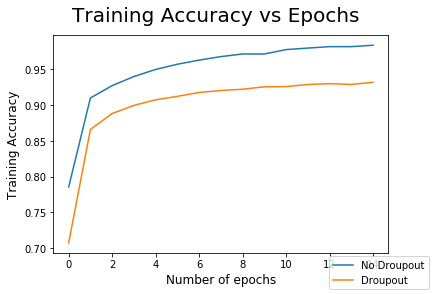

In [48]:
fig = plt.figure()
plt.plot(nn.accuracy_history[:15],label='No Droupout')
plt.plot(mm.accuracy_history,label='Droupout')
fig.suptitle('Training Accuracy vs Epochs', fontsize=20)
fig.legend(loc='lower right')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)

Text(0,0.5,'Loss')

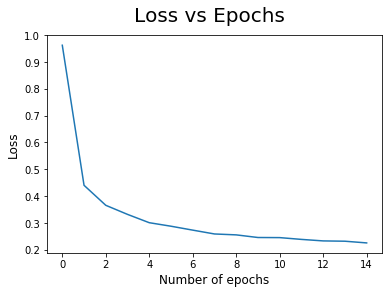

In [41]:
fig = plt.figure()
plt.plot(mm.loss_history)
fig.suptitle('Loss vs Epochs', fontsize=20)
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

In [49]:
#Classifier with RMS Prop

mm = model(x_train,y_train,10,alpha=0.001,accuracy=0.99,optimizer='RMS')
mayer1 = layer(784,196)
mayer2 = layer(196,58)
mayer3 = layer(58,10,activation='softmax')
mm.add(mayer1)
mm.add(mayer2)
mm.add(mayer3)
mm.train()

0
0.9353666666666667
1
0.9699333333333333
2
0.9774666666666667
3
0.9822166666666666
4
0.9845333333333334
5
0.9873833333333333
6


KeyboardInterrupt: 

Text(0,0.5,'Training Accuracy')

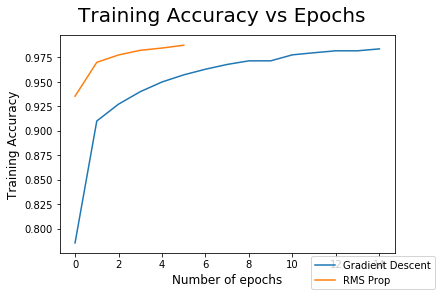

In [51]:
fig = plt.figure()
plt.plot(nn.accuracy_history[:15],label='Gradient Descent')
plt.plot(mm.accuracy_history,label='RMS Prop')
fig.suptitle('Training Accuracy vs Epochs', fontsize=20)
fig.legend(loc='lower right')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)